# New Supplemental figures

# Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import ttest_ind, pearsonr
import pickle

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    publication_style_ax,
    plot_violins_w_percent,
    plot_motif_boxplot_stripplot,
    calculate_subplot_coordinates,
)
from rna_motif_library.dataframe_tools import (  # pyright: ignore[reportMissingImports]
    add_motif_indentifier_columns,
)

In [4]:
DATA_PATH = "../../data"
SCRIPT_DATA_PATH = "../../scripts/"

## added functions

In [5]:
def load_dict_from_pickle(filename):
    """
    Load a dictionary from a pickle file.

    Args:
        filename (str): The path to the pickle file.

    Returns:
        dict: The loaded dictionary.
    """
    with open(filename, "rb") as f:
        return pickle.load(f)

In [6]:
def get_r2(x, y):
    """
    Calculate the coefficient of determination (R^2) for two variables.

    Args:
    x (array-like): The first variable.
    y (array-like): The second variable.

    Returns:
    float: The R^2 value, which represents the proportion of the variance in the dependent variable
           that is predictable from the independent variable.
    """
    return pearsonr(x, y)[0] ** 2

In [7]:
def extract_pdb_id(pdb_path):
    """
    Extracts the PDB ID (e.g., '1UN6') from a path like 'data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0'.

    Args:
        pdb_path (str): The path string containing the PDB ID.

    Returns:
        str: The extracted PDB ID, or None if not found.
    """
    import re

    # Find the last part of the path
    last_part = pdb_path.split("/")[-1]
    # Search for a pattern like .1UN6. in the last part
    match = re.search(r"\.([0-9A-Za-z]{4})\.", last_part)
    if match:
        return match.group(1)
    # If not found, try to find a 4-character PDB ID anywhere in the string
    match = re.search(r"([0-9A-Za-z]{4})", last_part)
    if match:
        return match.group(1)
    return None

In [8]:
def combine_old_and_new_data(df_old, df_new, data_type="reactivity"):
    """
    Combine old and new dataframes on the 'motif_name' column.

    Parameters:
    """
    df_old = df_old.copy()
    df_new = df_new.copy()
    if data_type == "reactivity":
        df_new.rename(columns={"ln_reactivity": "ln_r_data_mean"}, inplace=True)
        df = pd.concat([df_old, df_new])
        return df
    else:
        df_new.rename(columns={"reactivity_ratio": "ln_r_data_mean"}, inplace=True)

In [9]:
def get_best_fit_line(df, x_col, y_col):
    X = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    return model

In [10]:
# Function to create scatter plot with linear regression for distance vs reactivity analysis
def create_scatter_plot_w_regression(df, ax, x_col, y_col, color_by_pdb_res=False):
    # Prepare the data
    X = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Compute R-squared
    r2 = r2_score(y, model.predict(X))

    if color_by_pdb_res:
        scatter = ax.scatter(X.flatten(), y, s=6, c=df["pdb_res"], cmap="viridis")
        plt.colorbar(scatter, ax=ax, label="PDB Residue")
    else:
        ax.scatter(X.flatten(), y, s=6)

    # Add regression line
    ax.plot(X, model.predict(X), color="black", linewidth=1)

    return r2

## load data

In [11]:
df_pdb = pd.read_json(f"{SCRIPT_DATA_PATH}/pdb_info.json")

In [12]:
df_corr_data = pd.read_csv(f"{DATA_PATH}/pdb-features/non_canonical_atom_distances.csv")
df_ratio_corr_data = pd.read_csv(
    f"{DATA_PATH}/pdb-features/non_canonical_atom_distances_with_ratio.csv"
)
df_corr_new_data = pd.read_csv(f"{SCRIPT_DATA_PATH}/non_wc_distances.csv")
df_corr_new_summary = pd.read_csv(
    f"{SCRIPT_DATA_PATH}/non_wc_distances_reactivity_correlation.csv"
)

In [13]:
df_corr_data["pdb_id"] = df_corr_data["pdb_name"].apply(extract_pdb_id)

In [14]:
path = "/Users/jyesselman2/Dropbox/2_code/python/rna_motif_library/data/summaries/non_redundant_motifs.csv"
df_unique = pd.read_csv(path)
unique = {row["motif_name"]: 1 for i, row in df_unique.iterrows()}
hbonds_dict = load_dict_from_pickle(f"{SCRIPT_DATA_PATH}/motif_hbonds.pkl")
is_isolatable = {}
for k, v in hbonds_dict.items():
    if v["is_isolatable"]:
        is_isolatable[k] = 1
df_exclude = pd.read_csv(f"{SCRIPT_DATA_PATH}/exclude.csv")
exclude = {row["motif_name"]: 1 for i, row in df_exclude.iterrows()}

In [15]:
df_corr_new_data = df_corr_new_data.query("motif_name in @unique")
df_corr_new_data = df_corr_new_data.query("motif_name in @is_isolatable")
df_corr_new_data = df_corr_new_data.query("motif_name not in @exclude")
df_corr_new_data = df_corr_new_data.query("reactivity != 0")
df_corr_new_data["ln_reactivity"] = np.log(df_corr_new_data["reactivity"])
df_corr_new_data["ln_reactivity_ratio"] = np.log(df_corr_new_data["reactivity_ratio"])

df_corr_new_data["pair"] = (
    df_corr_new_data["pair"].str[0] + "-" + df_corr_new_data["pair"].str[1]
)

In [16]:
print(df_corr_data.iloc[0])

pdb_name               data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...
pdb_r_pos                                                              8
pair_pdb_r_pos                                                        15
pdb_r_bp_type                                                        tHS
distance                                                           15.61
average_b_factor                                              141.182727
normalized_b_factor                                            41.558651
pdb_res                                                              3.1
ln_r_data_mean                                                 -4.090945
ln_r_data_std                                                   0.323147
pair                                                                 A-G
atom1                                                                  P
atom2                                                                  P
r2                                                 

In [17]:
print(df_corr_new_data.iloc[0])

atom_1                                         P
atom_2                                         P
distance                                   20.27
reactivity                                0.0127
reactivity_ratio                          1.9328
motif_name             TWOWAY-1-1-AAA-UAU-5MRC-1
m_sequence                               AAA&UAU
pair                                         A-A
ln_reactivity                          -4.366153
ln_reactivity_ratio                      0.65897
Name: 484, dtype: object


# Plots

## Supplemental Figure XXX: new atomic distance correlations from structures that didnt have structures

### Subplot A: A-G correlations

A-G P-P original data r2 0.5068710179916264
A-G P-P number of original data points 122
A-G P-P new data r2 0.7257763761700462
A-G P-P number of new data points 91
A-G P-P combined data r2 0.6182110911930211


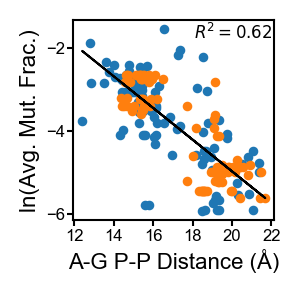

In [18]:
def plot_ag_correlation(df_corr_data, df_corr_new_data, df_pdb, ax):
    """
    Plots A-G P-P distance vs ln(Avg. Mut. Frac.) for both original and new data on the given axis.

    Args:
        df_corr_data (pd.DataFrame): Original correlation data.
        df_corr_new_data (pd.DataFrame): New correlation data.
        df_pdb (pd.DataFrame): DataFrame with PDB info to merge on 'pdb_id'.
        ax (matplotlib.axes.Axes): Axis to plot on.

    Returns:
        None
    """
    # get original data
    df_corr_data_ag = df_corr_data.query(
        'pair == "A-G" and atom1 == "P" and atom2 == "P"'
    ).copy()
    df_corr_data_ag.sort_values(by="distance", ascending=False, inplace=True)
    print(
        "A-G P-P original data r2",
        get_r2(df_corr_data_ag["distance"], df_corr_data_ag["ln_r_data_mean"]),
    )
    print(f"A-G P-P number of original data points", len(df_corr_data_ag))
    df_corr_data_ag = df_corr_data_ag.merge(df_pdb, on="pdb_id")
    # get new data
    df_corr_new_data_ag = df_corr_new_data.query(
        'pair == "A-G" and atom_1 == "P" and atom_2 == "P"'
    ).copy()
    df_corr_new_data_ag.sort_values(by="distance", ascending=False, inplace=True)
    df_corr_new_data_ag = add_motif_indentifier_columns(
        df_corr_new_data_ag, "motif_name"
    )
    df_corr_new_data_ag = df_corr_new_data_ag.merge(df_pdb, on="pdb_id")
    print(
        "A-G P-P new data r2",
        get_r2(df_corr_new_data_ag["distance"], df_corr_new_data_ag["ln_reactivity"]),
    )
    print(f"A-G P-P number of new data points", len(df_corr_new_data_ag))
    # combine data
    df_combined_ag = combine_old_and_new_data(df_corr_data_ag, df_corr_new_data_ag)
    model = get_best_fit_line(df_combined_ag, "distance", "ln_r_data_mean")
    X = df_combined_ag["distance"].values.reshape(-1, 1)
    y = df_combined_ag["ln_r_data_mean"].values
    y_pred = model.predict(X)
    ax.scatter(df_corr_data_ag["distance"], df_corr_data_ag["ln_r_data_mean"], s=6)
    ax.scatter(
        df_corr_new_data_ag["distance"], df_corr_new_data_ag["ln_reactivity"], s=6
    )
    ax.plot(X, y_pred, color="black", linewidth=0.75)
    ax.set_xlabel("A-G P-P Distance (Å)", labelpad=2)
    ax.set_ylabel("ln(Avg. Mut. Frac.)", labelpad=2)
    ax.set_xticks([12, 14, 16, 18, 20, 22])
    print(
        "A-G P-P combined data r2",
        get_r2(df_combined_ag["distance"], df_combined_ag["ln_r_data_mean"]),
    )
    # Add R2 annotation in the top right corner
    r2_value = get_r2(df_combined_ag["distance"], df_combined_ag["ln_r_data_mean"])
    ax.text(
        0.99,
        0.99,
        f"$R^2 = {r2_value:.2f}$",
        transform=ax.transAxes,
        fontsize=6,
        fontname="Arial",
        verticalalignment="top",
        horizontalalignment="right",
    )
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(figsize=(1.3, 1.3), dpi=200)
plot_ag_correlation(df_corr_data, df_corr_new_data, df_pdb, ax)

In [19]:
def get_ag_correlation_stats(df_corr_data, df_corr_new_data, df_pdb):
    # get original data ################################################################
    df_corr_data_ag = df_corr_data.query(
        'pair == "A-G" and atom1 == "P" and atom2 == "P"'
    ).copy()
    df_corr_data_ag.sort_values(by="distance", ascending=False, inplace=True)
    print(
        "A-G P-P original data r2",
        get_r2(df_corr_data_ag["distance"], df_corr_data_ag["ln_r_data_mean"]),
    )
    print(f"A-G P-P number of original data points", len(df_corr_data_ag))
    print(
        f"A-G P-P number of original unique pdbs",
        len(df_corr_data_ag["pdb_name"].unique()),
    )

    # get new data #####################################################################
    df_corr_data_ag = df_corr_data_ag.merge(df_pdb, on="pdb_id")
    df_corr_new_data_ag = df_corr_new_data.query(
        'pair == "A-G" and atom_1 == "P" and atom_2 == "P"'
    ).copy()
    df_corr_new_data_ag.sort_values(by="distance", ascending=False, inplace=True)
    df_corr_new_data_ag = add_motif_indentifier_columns(
        df_corr_new_data_ag, "motif_name"
    )
    df_corr_new_data_ag = df_corr_new_data_ag.merge(df_pdb, on="pdb_id")
    print(
        "A-G P-P new data r2",
        get_r2(df_corr_new_data_ag["distance"], df_corr_new_data_ag["ln_reactivity"]),
    )
    print(f"A-G P-P number of new data points", len(df_corr_new_data_ag))
    print(
        f"A-G P-P number of new unique pdbs",
        len(df_corr_new_data_ag["pdb_id"].unique()),
    )
    print(
        f"A-G P-P number of new unique motifs",
        len(df_corr_new_data_ag["m_sequence"].unique()),
    )

    # combine data #####################################################################
    df_combined_ag = combine_old_and_new_data(df_corr_data_ag, df_corr_new_data_ag)
    model = get_best_fit_line(df_combined_ag, "distance", "ln_r_data_mean")
    print(
        "A-G P-P combined data r2",
        get_r2(df_combined_ag["distance"], df_combined_ag["ln_r_data_mean"]),
    )
    # Add R2 annotation in the top right corner
    r2_value = get_r2(df_combined_ag["distance"], df_combined_ag["ln_r_data_mean"])


get_ag_correlation_stats(df_corr_data, df_corr_new_data, df_pdb)

A-G P-P original data r2 0.5068710179916264
A-G P-P number of original data points 122
A-G P-P number of original unique pdbs 80
A-G P-P new data r2 0.7257763761700462
A-G P-P number of new data points 91
A-G P-P number of new unique pdbs 51
A-G P-P number of new unique motifs 23
A-G P-P combined data r2 0.6182110911930211


### Subplot B: C-A correlations

C-A O3'-C2' original data r2 0.5139449403790022
C-A O3'-C2' new data r2 0.02751559379250192
C-A O3'-C2' combined data r2 0.29575642178439676


<Axes: xlabel="C-A O3'-C2' Distance (Å)", ylabel='ln(Avg. Mut. Frac.)'>

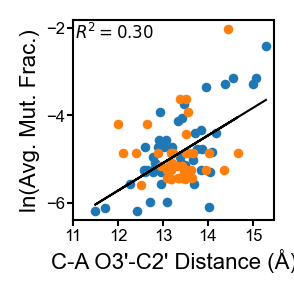

In [20]:
def plot_ca_correlation(df_corr_data, df_corr_new_data, ax=None):
    """
    Plots the C-A O3'-C2' correlation using both original and new data, fits a regression line,
    and prints R^2 values.

    Args:
        df_corr_data (pd.DataFrame): Original correlation data.
        df_corr_new_data (pd.DataFrame): New correlation data.
        ax (matplotlib.axes.Axes, optional): Axes to plot on. If None, creates new figure and axes.

    Returns:
        matplotlib.axes.Axes: The axes with the plot.
    """
    # get original data
    df_corr_data_ca = df_corr_data.query(
        'pair == "C-A" and atom1 == "O3\'" and atom2 == "C2\'"'
    ).copy()
    df_corr_data_ca.sort_values(by="distance", ascending=False, inplace=True)
    print(
        "C-A O3'-C2' original data r2",
        get_r2(df_corr_data_ca["distance"], df_corr_data_ca["ln_r_data_mean"]),
    )
    # get new data
    df_corr_new_data_ca = df_corr_new_data.query(
        'pair == "C-A" and atom_1 == "O3\'" and atom_2 == "C2\'"'
    ).copy()
    df_corr_new_data_ca.sort_values(by="distance", ascending=False, inplace=True)
    print(
        "C-A O3'-C2' new data r2",
        get_r2(df_corr_new_data_ca["distance"], df_corr_new_data_ca["ln_reactivity"]),
    )
    # combine data
    df_combined_ac = combine_old_and_new_data(df_corr_data_ca, df_corr_new_data_ca)
    model = get_best_fit_line(df_combined_ac, "distance", "ln_r_data_mean")
    X = df_combined_ac["distance"].values.reshape(-1, 1)
    y = df_combined_ac["ln_r_data_mean"].values
    y_pred = model.predict(X)
    if ax is None:
        fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)
    ax.scatter(df_corr_data_ca["distance"], df_corr_data_ca["ln_r_data_mean"], s=6)
    ax.scatter(
        df_corr_new_data_ca["distance"], df_corr_new_data_ca["ln_reactivity"], s=6
    )
    ax.plot(X, y_pred, color="black", linewidth=0.75)
    ax.set_xlabel("C-A O3'-C2' Distance (Å)", labelpad=2)
    ax.set_ylabel("ln(Avg. Mut. Frac.)", labelpad=2)
    ax.set_xticks([11, 12, 13, 14, 15])
    ax.set_yticks([-6, -4, -2])
    r2_value = get_r2(df_combined_ac["distance"], df_combined_ac["ln_r_data_mean"])
    ax.text(
        0.01,
        0.99,
        f"$R^2 = {r2_value:.2f}$",
        transform=ax.transAxes,
        fontsize=6,
        fontname="Arial",
        verticalalignment="top",
        horizontalalignment="left",
    )
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)
    print(
        "C-A O3'-C2' combined data r2",
        get_r2(df_combined_ac["distance"], df_combined_ac["ln_r_data_mean"]),
    )
    return ax


# Example usage:
fig, ax = plt.subplots(figsize=(1.3, 1.3), dpi=200)
plot_ca_correlation(df_corr_data, df_corr_new_data, ax)

In [21]:
def get_ca_correlation_stats(df_corr_data, df_corr_new_data, df_pdb):
    # get original data ################################################################
    df_corr_data_ca = df_corr_data.query(
        'pair == "C-A" and atom1 == "O3\'" and atom2 == "C2\'"'
    ).copy()
    df_corr_data_ca.sort_values(by="distance", ascending=False, inplace=True)
    print(
        "C-A O3'-C2' original data r2",
        get_r2(df_corr_data_ca["distance"], df_corr_data_ca["ln_r_data_mean"]),
    )
    print(
        f"C-A O3'-C2' number of original unique pdbs",
        len(df_corr_data_ca["pdb_name"].unique()),
    )
    # get new data #####################################################################
    df_corr_new_data_ca = df_corr_new_data.query(
        'pair == "C-A" and atom_1 == "O3\'" and atom_2 == "C2\'"'
    ).copy()
    df_corr_new_data_ca = add_motif_indentifier_columns(
        df_corr_new_data_ca, "motif_name"
    )
    df_corr_new_data_ca = df_corr_new_data_ca.merge(df_pdb, on="pdb_id")
    df_corr_new_data_ca.sort_values(by="distance", ascending=False, inplace=True)
    print(
        "C-A O3'-C2' new data r2",
        get_r2(df_corr_new_data_ca["distance"], df_corr_new_data_ca["ln_reactivity"]),
    )
    print(
        f"C-A O3'-C2' number of new unique pdbs",
        len(df_corr_new_data_ca["pdb_id"].unique()),
    )
    print(
        f"C-A O3'-C2' number of new unique motifs",
        len(df_corr_new_data_ca["m_sequence"].unique()),
    )

    # combine data
    df_combined_ac = combine_old_and_new_data(df_corr_data_ca, df_corr_new_data_ca)
    r2_value = get_r2(df_combined_ac["distance"], df_combined_ac["ln_r_data_mean"])

    print(
        "C-A O3'-C2' combined data r2",
        get_r2(df_combined_ac["distance"], df_combined_ac["ln_r_data_mean"]),
    )


get_ca_correlation_stats(df_corr_data, df_corr_new_data, df_pdb)

C-A O3'-C2' original data r2 0.5139449403790022
C-A O3'-C2' number of original unique pdbs 35
C-A O3'-C2' new data r2 0.02751559379250192
C-A O3'-C2' number of new unique pdbs 39
C-A O3'-C2' number of new unique motifs 13
C-A O3'-C2' combined data r2 0.29575642178439676


### Subplot C: C-C correlations

C-C O3'-OP2' original data r2 0.6365635588287755
C-C O3'-OP2' new data r2 0.20752050535942115
C-C O3'-OP2' combined data r2 0.42652994558901103


<Axes: xlabel="C-C O3'-OP2' Distance (Å)", ylabel='ln(Avg. Mut. Frac.)'>

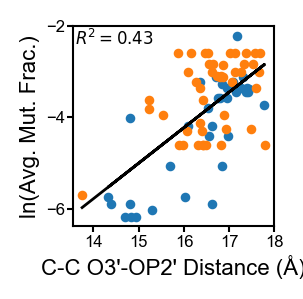

In [22]:
def plot_cc_correlation(df_corr_data, df_corr_new_data, ax=None):
    """
    Plot C-C O3'-OP2' correlation using original and new data, fit line, and show R^2 in upper left.
    """
    # get original data
    df_corr_data_cc = df_corr_data.query(
        'pair == "C-C" and atom1 == "O3\'" and atom2 == "OP2"'
    ).copy()
    df_corr_data_cc.sort_values(by="distance", ascending=False, inplace=True)

    r2_orig = get_r2(df_corr_data_cc["distance"], df_corr_data_cc["ln_r_data_mean"])
    print("C-C O3'-OP2' original data r2", r2_orig)

    # get new data
    df_corr_data_new_cc = df_corr_new_data.query(
        'pair == "C-C" and atom_1 == "O3\'" and atom_2 == "O2P"'
    ).copy()
    df_corr_data_new_cc.sort_values(by="distance", ascending=False, inplace=True)

    r2_new = get_r2(
        df_corr_data_new_cc["distance"], df_corr_data_new_cc["ln_reactivity"]
    )
    print("C-C O3'-OP2' new data r2", r2_new)

    # combine data
    df_combined_cc = combine_old_and_new_data(df_corr_data_cc, df_corr_data_new_cc)
    model = get_best_fit_line(df_combined_cc, "distance", "ln_r_data_mean")
    X = df_combined_cc["distance"].values.reshape(-1, 1)
    y = df_combined_cc["ln_r_data_mean"].values
    y_pred = model.predict(X)

    if ax is None:
        fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)
    ax.scatter(df_corr_data_cc["distance"], df_corr_data_cc["ln_r_data_mean"], s=6)
    ax.scatter(
        df_corr_data_new_cc["distance"], df_corr_data_new_cc["ln_reactivity"], s=6
    )
    ax.plot(X, y_pred, color="black", linewidth=1)
    ax.set_xlabel("C-C O3'-OP2' Distance (Å)", labelpad=2)
    ax.set_ylabel("ln(Avg. Mut. Frac.)", labelpad=2)
    ax.set_xticks([14, 15, 16, 17, 18])
    ax.set_yticks([-6, -4, -2])
    r2_combined = get_r2(df_combined_cc["distance"], df_combined_cc["ln_r_data_mean"])
    ax.text(
        0.01,
        0.99,
        f"$R^2 = {r2_combined:.2f}$",
        transform=ax.transAxes,
        fontsize=6,
        fontname="Arial",
        verticalalignment="top",
        horizontalalignment="left",
    )
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)
    print("C-C O3'-OP2' combined data r2", r2_combined)
    return ax


# Example usage:
fig, ax = plt.subplots(figsize=(1.3, 1.3), dpi=200)
plot_cc_correlation(df_corr_data, df_corr_new_data, ax)

In [ ]:
def get_cc_correlation_stats(df_corr_data, df_corr_new_data, df_pdb):
    # get original data ################################################################
    df_corr_data_cc = df_corr_data.query(
        'pair == "C-C" and atom1 == "O3\'" and atom2 == "OP2"'
    ).copy()
    df_corr_data_cc.sort_values(by="distance", ascending=False, inplace=True)
    print(
        "C-C O3'-OP2' original data r2",
        get_r2(df_corr_data_cc["distance"], df_corr_data_cc["ln_r_data_mean"]),
    )
    print(
        f"C-C O3'-OP2' number of original unique pdbs",
        len(df_corr_data_cc["pdb_name"].unique()),
    )
    # get new data #####################################################################
    df_corr_new_data_cc = df_corr_new_data.query(
        'pair == "C-C" and atom_1 == "O3\'" and atom_2 == "O2P"'
    ).copy()
    df_corr_new_data_cc = add_motif_indentifier_columns(
        df_corr_new_data_cc, "motif_name"
    )
    df_corr_new_data_cc = df_corr_new_data_cc.merge(df_pdb, on="pdb_id")
    df_corr_new_data_cc.sort_values(by="distance", ascending=False, inplace=True)
    print(
        "C-C O3'-OP2' new data r2",
        get_r2(df_corr_new_data_cc["distance"], df_corr_new_data_cc["ln_reactivity"]),
    )
    print(
        f"C-C O3'-OP2' number of new unique pdbs",
        len(df_corr_new_data_cc["pdb_id"].unique()),
    )
    print(
        f"C-A O3'-C2' number of new unique motifs",
        len(df_corr_new_data_cc["m_sequence"].unique()),
    )

    # combine data
    df_combined_ac = combine_old_and_new_data(df_corr_data_cc, df_corr_new_data_cc)
    r2_value = get_r2(df_combined_ac["distance"], df_combined_ac["ln_r_data_mean"])

    print(
        "C-A O3'-C2' combined data r2",
        get_r2(df_combined_ac["distance"], df_combined_ac["ln_r_data_mean"]),
    )


get_cc_correlation_stats(df_corr_data, df_corr_new_data, df_pdb)

C-C O3'-OP2' original data r2 0.6365635588287755
C-C O3'-OP2' number of original unique pdbs 16
C-C O3'-OP2' new data r2 0.20752050535942115
C-C O3'-OP2' number of new unique pdbs 20
C-A O3'-C2' number of new unique motifs 9
C-A O3'-C2' combined data r2 0.42652994558901103


In [23]:
df_corr_new_summary_cc = df_corr_new_summary.query('pair == "C-C"')
df_corr_new_summary_cc.sort_values(by="r2", ascending=False, inplace=True)
df_corr_new_summary_cc.head(20)

/var/folders/lg/b_1r07zd7174kpbyfysdr7p0dxd870/T/ipykernel_2077/872181496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_new_summary_cc.sort_values(by="r2", ascending=False, inplace=True)


,atom_1,atom_2,pair,count,r2_avg,r2,min_distance,max_distance,r2_avg_ratio,r2_ratio
790,O2',O5',C-C,48,0.729,0.247,12.7750,15.5150,0.147,0.088
835,C2',O5',C-C,48,0.675,0.230,12.6000,14.7800,0.097,0.079
847,O2',P,C-C,48,0.690,0.228,14.0650,16.5200,0.173,0.097
853,O3',O5',C-C,48,0.692,0.226,14.6150,16.8050,0.158,0.069
874,O2',O1P,C-C,48,0.669,0.217,15.0850,17.7850,0.172,0.089
882,O3',P,C-C,48,0.612,0.214,15.8400,17.6450,0.173,0.089
897,C2',P,C-C,48,0.607,0.208,13.8000,15.6850,0.115,0.094
920,C1',O5',C-C,48,0.730,0.200,12.3700,14.2300,0.061,0.068
927,C3',O5',C-C,48,0.616,0.199,13.8600,15.7250,0.093,0.064
939,O3',O1P,C-C,48,0.620,0.196,16.9800,19.0000,0.186,0.073


A-G P-P original data r2 0.5068710179916264
A-G P-P number of original data points 122
A-G P-P new data r2 0.7257763761700462
A-G P-P number of new data points 91
A-G P-P combined data r2 0.6182110911930211
C-A O3'-C2' original data r2 0.5139449403790022
C-A O3'-C2' new data r2 0.02751559379250192
C-A O3'-C2' combined data r2 0.29575642178439676
C-C O3'-OP2' original data r2 0.6365635588287755
C-C O3'-OP2' new data r2 0.20752050535942115
C-C O3'-OP2' combined data r2 0.42652994558901103


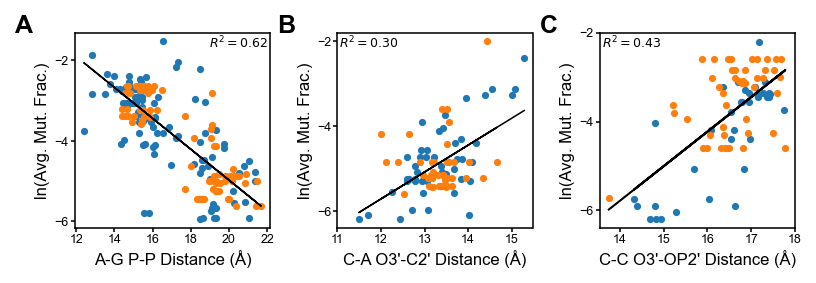

In [24]:
fig_size = (7, 4)
layout = (1, 4)
subplot_size = (1.3, 1.3)  # Each subplot is 4" x 3"
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.30, "right": 0.0, "top": 0.0, "bottom": 0.70},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)

fig = plt.figure(figsize=fig_size, dpi=150)
ax1 = fig.add_axes(coords_list[0])
plot_ag_correlation(df_corr_data, df_corr_new_data, df_pdb, ax1)

ax2 = fig.add_axes(coords_list[1])
plot_ca_correlation(df_corr_data, df_corr_new_data, ax2)

ax3 = fig.add_axes(coords_list[2])
plot_cc_correlation(df_corr_data, df_corr_new_data, ax3)

letters = ["A", "B", "C"]
for i, letter in enumerate(letters):
    fig.text(
        coords_list[i][0] - 0.4 / fig_size[0],
        coords_list[i][1] + 1.3 / fig_size[1],
        letter,
        fontsize=12,
        weight="bold",
        fontname="Arial",
    )

## Supplemental Figure XXX: high resolution structure give better correlations

### Subplot A: A-G correlations

A-G P-P original data r2 0.4254696062987287
A-G P-P new data r2 0.7530673945513655
A-G P-P combined data r2 0.590082766987977


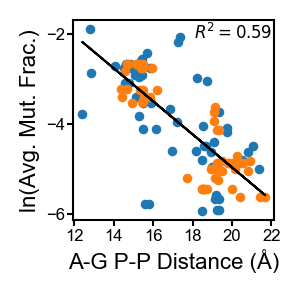

In [25]:
def plot_ag_correlation_by_resolution(
    df_corr_data, df_corr_new_data, df_pdb, resolution, ax
):
    """
    Plots A-G P-P distance vs ln(Avg. Mut. Frac.) for both original and new data on the given axis.

    Args:
        df_corr_data (pd.DataFrame): Original correlation data.
        df_corr_new_data (pd.DataFrame): New correlation data.
        df_pdb (pd.DataFrame): DataFrame with PDB info to merge on 'pdb_id'.
        ax (matplotlib.axes.Axes): Axis to plot on.

    Returns:
        None
    """
    # get original data
    df_corr_data_ag = df_corr_data.query(
        'pair == "A-G" and atom1 == "P" and atom2 == "P"'
    ).copy()
    df_corr_data_ag.sort_values(by="distance", ascending=False, inplace=True)
    df_corr_data_ag = df_corr_data_ag.query(f"pdb_res < {resolution}")
    print(
        "A-G P-P original data r2",
        get_r2(df_corr_data_ag["distance"], df_corr_data_ag["ln_r_data_mean"]),
    )
    df_corr_data_ag = df_corr_data_ag.merge(df_pdb, on="pdb_id")
    # get new data
    df_corr_new_data_ag = df_corr_new_data.query(
        'pair == "A-G" and atom_1 == "P" and atom_2 == "P"'
    ).copy()
    df_corr_new_data_ag.sort_values(by="distance", ascending=False, inplace=True)
    df_corr_new_data_ag = add_motif_indentifier_columns(
        df_corr_new_data_ag, "motif_name"
    )
    df_corr_new_data_ag = df_corr_new_data_ag.merge(df_pdb, on="pdb_id")
    df_corr_new_data_ag = df_corr_new_data_ag.query(f"resolution < {resolution}")

    print(
        "A-G P-P new data r2",
        get_r2(df_corr_new_data_ag["distance"], df_corr_new_data_ag["ln_reactivity"]),
    )
    # combine data
    df_combined_ag = combine_old_and_new_data(df_corr_data_ag, df_corr_new_data_ag)
    model = get_best_fit_line(df_combined_ag, "distance", "ln_r_data_mean")
    X = df_combined_ag["distance"].values.reshape(-1, 1)
    y = df_combined_ag["ln_r_data_mean"].values
    y_pred = model.predict(X)
    ax.scatter(df_corr_data_ag["distance"], df_corr_data_ag["ln_r_data_mean"], s=6)
    ax.scatter(
        df_corr_new_data_ag["distance"], df_corr_new_data_ag["ln_reactivity"], s=6
    )
    ax.plot(X, y_pred, color="black", linewidth=0.75)
    ax.set_xlabel("A-G P-P Distance (Å)", labelpad=2)
    ax.set_ylabel("ln(Avg. Mut. Frac.)", labelpad=2)
    ax.set_xticks([12, 14, 16, 18, 20, 22])
    print(
        "A-G P-P combined data r2",
        get_r2(df_combined_ag["distance"], df_combined_ag["ln_r_data_mean"]),
    )
    # Add R2 annotation in the top right corner
    r2_value = get_r2(df_combined_ag["distance"], df_combined_ag["ln_r_data_mean"])
    ax.text(
        0.99,
        0.99,
        f"$R^2 = {r2_value:.2f}$",
        transform=ax.transAxes,
        fontsize=6,
        fontname="Arial",
        verticalalignment="top",
        horizontalalignment="right",
    )
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(figsize=(1.3, 1.3), dpi=200)
plot_ag_correlation_by_resolution(df_corr_data, df_corr_new_data, df_pdb, 3.0, ax)